# Individual contact matrices from activities
The objective in this part is to obtain, at least for a sample of the population, the number of daily contacts with other individuals. The contacts are split into groups depending on the type of activity in which the contact happened, as well as the age of the target person.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sparse

## Loading data
The dataframe ```data/matsim_population_activities.csv``` contains the list of all activities for each individual based on the MATSIM simulation.

In [2]:
activities_df = pd.read_csv('../data/matsim_population_activities.csv')
activities_df.head(10)

,id,type,facility,link,x,y
0,100000,home,home40692,542062,2689459.0,1255462.0
1,100000,education,358532,184266,2689282.0,1255389.0
2,100000,home,home40692,542062,2689459.0,1255462.0
3,100000,education,484020,184266,2689282.0,1255389.0
4,100000,home,home40692,542062,2689459.0,1255462.0
5,100000,shop,601754,355392,2689600.0,1255500.0
6,100000,home,home40692,542062,2689459.0,1255462.0
7,100000,shop,125790,355330,2689674.0,1255464.0
8,100000,home,home40692,542062,2689459.0,1255462.0
9,1000005,home,home422688,61971,2700184.0,1259308.0


Let's have a look at how many unique values each column contains:

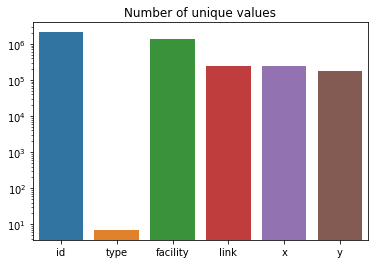

In [3]:
unique_values_counts = pd.Series({col: activities_df[col].drop_duplicates().shape[0] for col in activities_df.columns})
sns.barplot(x=unique_values_counts.index, y=unique_values_counts.values, log=True)
plt.title('Number of unique values')
plt.show()

## Who met who ?
The problem is the following: given an individual $I\in P$, can we efficiently find the set of all individuals $I$ has been in contact
with during the day ?   
"Being in contact" here means visiting a common facility at least once.

The naive way to do this would be to obtain the list of all facilities $I$ visited, and then for all such facilities check for every other person
whether they have visited it. However this obliges to browse the activities of every other individual, so the total complexity is $O(A)$  
where $A$ is the number of total activities recorded. Now, we need to do this for every person in a sampled population (let's say at least 100000 people).
Considering $A \approx$ 10 million, this method isn't tractable.

Another method is to use a *presence matrix*: a matrix $M$ of shape $(|P|, N_{facilities})$ such that for any individual $i$ and facility $f$, $M_{i,f} =$ 1 if $i$ visited $f$ and 0 otherwise. Given the number of people in the population and the number of unique facilities, we'd never store the full matrix in memory.
However any person only visits a small number of facilities during the day (how many places do you visit in a single day ? Probably much fewer than a hundred). Thus $M$ is extremely **sparse** and can be efficiently stored using the CSR and CSC formats.  

Once $M$ is created under *both* CSR and CSC formats, we can retrieve the list of the people an individual $i$ met in the following manner:
* Retrieve the non-zero indices of row $i$ in the CSR matrix - those give which facilities $i$ visited.
* For each facility f:
* Retrieve the non-zero indices in col $f$ in the CSC matrix - those give which people visited $f$ during the day
* Compile the list of all people indices retrieved as such.  

Note that the final list will contain duplicates, and especially will include $i$ (since $i$ visited the same facilities as $i$..).  
For a single individual, retrieving the list of all contacts in this way is done in **constant time** $O(1)$.

**Remark**: the reason we use both CSR and CSC format is because we need to retrieve both rows and columns of the presence matrix. Each of those format allows to done one of those in constant time.

In [4]:
# We'll need to remove the rows in which the facility is null
activities_df = activities_df[activities_df['facility'].notna()]

In [5]:
# The facilities names are strings (such as 'home40692'), but the matrix indices
# will be integers starting at 0.
# Therefore we need to create an association between facility name and matrix
# column indices. This association is stored in a dictionnary facilities_dict.
unique_facilities = activities_df['facility'].drop_duplicates()
facilities_dict = {facility: index for index, facility in enumerate(unique_facilities)}
number_of_facilities = len(facilities_dict)

In [6]:
# The people IDs are not strings but are not sorted and not continuous
# (especially, they don't begin at 0). Thus we'll also create an association
# person ID --> matrix row index
unique_ids = activities_df['id'].drop_duplicates()
ids_dict = {person_id: index for index, person_id in enumerate(unique_ids)}
number_of_ids = len(ids_dict)

In [7]:
# To create the sparse matrix, we need to rows and columns of each non-zero elements
# This corresponds to obtaining the 'id' and 'facility' columns in the activities dataframe,
# and replacing the names with the associated indexes.
ids_indexes = np.array(activities_df['id'].apply(lambda person_id: ids_dict[person_id]))
facility_indexes = np.array(activities_df['facility'].apply(lambda facility: facilities_dict[facility]))

In [8]:
# Creates the sparse matrices with the same data but under different formats
# See scipy's documentation for details
presence_matrix_csc = sparse.csc_matrix((np.full(activities_df.shape[0], 1), (ids_indexes, facility_indexes)))
presence_matrix_csr = sparse.csr_matrix(presence_matrix_csc)

In [9]:
presence_matrix_csr.shape

(2100000, 1392168)

In [10]:
def find_contacts(person_id):
    """
    Returns the IDs of all people a person met during
    the day.
    :person_id: int64, ID of the person who's contacts should be
        retrieved.
    :return: C, F where:
        - C is the list of IDs of all contacts over a day
        - F is the list of facility names at which each contact happened
        For example, C=[10003] F=["home4095"] means a single contact happened
        with person 10,003, at facility "home4095".
        The final list most likely contains duplicates and includes in the
        contacts person_id themselves.
    """
    # Retrieves the person's index in the presence matrix's
    # rows
    person_indx = ids_dict[person_id]
    # Retrieves the indexes in the presence matrix's columns
    # of the facilities the person visited
    activ_indexes = presence_matrix_csr[person_indx].indices
    
    # Will contain the indexes of all contacts
    contacts_indexes = []
    # Will contain the indexes of the facilities at which the contacts happened
    facilities_indxs = []
    for activ_indx in activ_indexes:
        # For each facility F
        # Retrieves the indexes in the presence matrix's column
        # corresponding to F
        # of the people who were at F at least once
        # during the day (i.e. non-zero elements of column F)
        new_contacts = list(presence_matrix_csc[:, activ_indx].indices)
        contacts_indexes += new_contacts
        facilities_indxs += [activ_indx for _  in new_contacts]
    return (np.array([unique_ids.iloc[indx] for indx in contacts_indexes]),
            np.array([unique_facilities.iloc[indx] for indx in facilities_indxs]))

## Building the contact matrix
The first step is to obtain for a sample of the population the list of all contacts as well as where (in which facility) they took place.

### Selecting a sample of IDs
Building the contact matrices for all people (around 2M) would take *some time*. Thus we only select a sample of the population:

In [11]:
sample_ids = activities_df['id'].sample(10000)

### Fetching the contacts

In [12]:
# For every person in the sample, retrieves the list of all people
# they met as well as where they met them
all_contacts, all_facilities, all_ids = [], [], []
for person_id in sample_ids:
    contacts, facilities = find_contacts(person_id)
    all_contacts.append(contacts)
    all_facilities.append(facilities)
    all_ids.append([person_id for _ in contacts])

In [13]:
contact_dataframe = pd.DataFrame({'id': np.concatenate(all_ids),
                                  'contact_id': np.concatenate(all_contacts),
                                  'facility': np.concatenate(all_facilities)})

In [14]:
contact_dataframe.iloc[:-20]

,id,contact_id,facility
0,7737759,7626139,472618
1,7737759,7737759,472618
2,7737759,7813558,472618
3,7737759,7813824,472618
4,7737759,7814738,472618
...,...,...,...
1459134,7788833,7789474,584798
1459135,7788833,7789528,584798
1459136,7788833,7789613,584798
1459137,7788833,7789639,584798


What we wanna do now is:
* Replace the contact ids with the age of the contacts
* Replace the facility names with their activity types  

While each person has a unique age, facilities might be of multiple types.

### Fetching the activity types

In [15]:
facilities_types = activities_df[['facility', 'type']]

array([[<AxesSubplot:title={'center':'type'}>]], dtype=object)

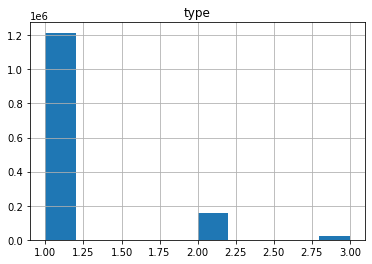

In [16]:
nb_types = facilities_types.drop_duplicates().groupby('facility').count()
nb_types.hist()

Some facilities (about 200,000) are counted into 2 or 3 types.  
For facilities that are counted multiple times, we'll chose the types in which they are most often represented. For example, if the facility is a school listed in 3 activities, once as 'work' (by a teacher) and twice as 'education' (by students) then the facility will **always** be considered as "education".  
This reasoning creates a proportion of mistakes, such as teachers going to school for an "educational" activity. Nonetheless this method has the advantage of being possible to do in practice regarding computation time.

In [17]:
# Counts the occurences of each (facility, activity type) pair in the activities,
# and sort them by facility and then by type count
fac_types_counts = facilities_types.value_counts().reset_index().sort_values(['facility', 0], ascending=False)
fac_types_counts.head()

,facility,type,0
627784,home999999,home,5
711581,home999995,home,4
1115314,home999989,home,2
433814,home999987,home,6
711583,home999986,home,4


In [18]:
# For facility, selects the pair (facility, type) that occurs most times
final_fac_types = fac_types_counts.groupby('facility').first().reset_index()[['facility', 'type']].set_index('facility')
final_fac_types.head()

,type
facility,
1,service
10,service
100,service
1000,work
10000,service


In [19]:
# For each activity in the contacts dataframe, fetches the facility type based on the previous
# result
contact_dataframe = contact_dataframe.merge(final_fac_types, left_on='facility', right_index=True)
contact_dataframe.sample(10)

,id,contact_id,facility,type
677937,29980,3920,359782,leisure
549036,7146225,2176227,446712,leisure
585982,8192980,8147511,94862,shop
101616,5865883,2656079,596375,leisure
1444539,2430015,2467510,293482,shop
713850,7729321,7635733,581415,leisure
396338,3549003,4198764,102691,work
308941,4468303,3915731,148735,work
1456843,4072111,4083630,332635,leisure
276540,7196636,4755220,290754,work


### Fetching the contact's age
All we need now to obtain the contact matrices is to retrieve the age of each contact in the contacts df.

In [20]:
population_data = pd.read_csv('../data/matsim_population_attributes.csv')
population_data.head()

,id,age,bikeAvailability,carAvail,employed,hasLicense,home_x,home_y,householdIncome,isCarPassenger,municipalityType,ptHasGA,ptHasHalbtax,ptHasStrecke,ptHasVerbund,sex,spRegion
0,100000,8,FOR_NONE,never,False,no,2689459.0,1255462.0,12000.0,True,urban,False,False,False,False,m,1.0
1,1000005,26,FOR_ALL,always,True,yes,2700184.0,1259308.0,4000.0,False,urban,False,True,False,False,f,1.0
2,1000006,45,FOR_ALL,always,True,yes,2699870.0,1264044.0,6000.0,False,urban,False,False,False,False,m,1.0
3,1000008,34,FOR_ALL,sometimes,True,yes,2695872.0,1260766.0,12000.0,False,urban,False,False,False,True,m,1.0
4,100001,46,FOR_NONE,always,True,yes,2689459.0,1255462.0,12000.0,False,urban,False,False,False,False,f,1.0


In [21]:
# Fetches the id-age association
id_age_df = population_data[['id', 'age']].drop_duplicates().set_index('id')
id_age_df.index.is_unique

True

In [22]:
contact_dataframe = contact_dataframe.merge(id_age_df, left_on='id', right_index=True)
contact_dataframe.sample(10)

,id,contact_id,facility,type,age
476635,557785,548043,459582,leisure,31
1252045,1294323,1881727,207211,work,47
1177990,1390103,1421209,11332,work,33
1392029,6719323,4287401,217883,leisure,11
320777,4407805,4491841,13988,leisure,7
642427,1444254,1735590,582024,leisure,11
803507,4803595,5548660,17178,leisure,71
522807,844405,1535272,612799,work,63
1397071,8133108,7825621,310010,leisure,78
1180614,5231075,5175656,202398,work,16


### Some stats
Distribution of the number of total contacts:

Text(0.5, 0, 'Number of contacts')

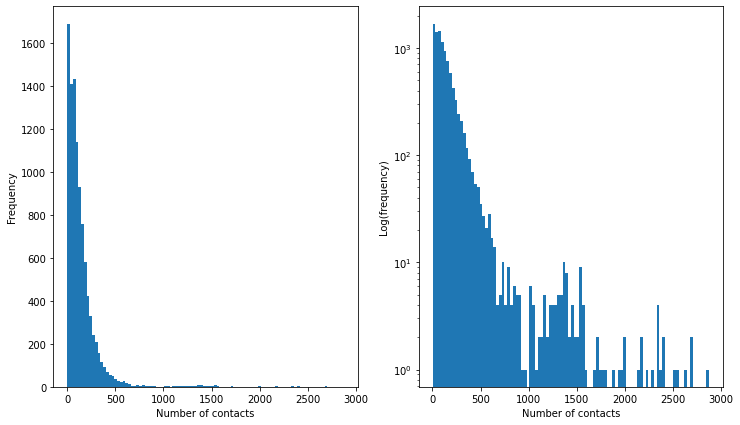

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
nb_contacts = contact_dataframe.groupby('id').count()['contact_id']
ax[0].hist(nb_contacts, bins=100)
ax[0].set_xlabel("Number of contacts")
ax[0].set_ylabel("Frequency")
ax[1].hist(nb_contacts, bins=100, log=True)
ax[1].set_ylabel("Log(frequency)")
ax[1].set_xlabel("Number of contacts")

The number of contacts seems to follow a power law: most people only meet around a few hundred people per day, while some meet up to more than 2000.

### Contact matrix for a single indiv

#### Age to age groups
Let's now map the age of each contact to an age group.

In [24]:
age_intervals = pd.DataFrame({'From': [0, 20, 65], 'To': [19, 64, 150], 'Group':['C', 'A', 'E']})
age_intervals

,From,To,Group
0,0,19,C
1,20,64,A
2,65,150,E


In [25]:
age_intervals = age_intervals.set_index(pd.IntervalIndex.from_arrays(age_intervals['From'], 
                                                             age_intervals['To']))['Group']

contact_dataframe['age_group'] = contact_dataframe['age'].map(age_intervals)
contact_dataframe.sample(10)

,id,contact_id,facility,type,age,age_group
1304473,7100972,7043323,71295,shop,54,A
20267,3581197,4000658,51553,leisure,47,A
1243912,8278991,8278992,home3649585,home,85,E
1035452,459093,459093,546129,leisure,42,A
279758,3560757,3560757,241656,work,58,A
996744,4932311,3587230,569565,shop,40,A
1003068,2581104,2807225,85090,shop,17,C
501273,3130438,3133052,476534,shop,40,A
523075,844405,2603004,612799,work,63,A
1216629,6371216,6348752,620950,work,27,A


#### Counting contacts per (ID, type, age_group)

In [55]:
contact_counts = contact_dataframe.groupby(['id', 'type', 'age_group']).count()['contact_id'].reset_index()
contact_counts = contact_counts.rename({'contact_id': 'contacts'}, axis=1)
contact_counts.sample(10)

,id,type,age_group,contacts
17966,5365135,education,A,62
27925,8264509,work,A,62
1593,458403,home,C,6
12772,3855488,home,A,2
17265,5166965,service,A,9
3874,1263281,shop,A,20
12904,3892823,home,C,2
15475,4632018,leisure,A,57
25877,7681524,home,A,4
16343,4897647,home,A,3


In [56]:
contact_counts = contact_counts.pivot(index='id', columns=['type', 'age_group'], values='contacts').fillna(0).sort_index(axis=1)
contact_counts.head()

type      education            home           leisure             service  \
age_group         A     C    E    A    C    E       A      C    E       A   
id                                                                          
827             0.0   0.0  0.0  2.0  0.0  0.0   162.0    0.0  0.0     0.0   
2528            0.0  19.0  0.0  0.0  4.0  0.0     0.0  137.0  0.0     0.0   
3363          163.0   0.0  0.0  4.0  0.0  0.0    70.0    0.0  0.0     0.0   
4299            0.0   0.0  0.0  4.0  0.0  0.0   167.0    0.0  0.0    25.0   
4627            0.0   0.0  0.0  0.0  5.0  0.0     0.0   16.0  0.0     0.0   

type                  shop            work             
age_group     C    E     A    C    E     A     C    E  
id                                                     
827         0.0  0.0  60.0  0.0  0.0   0.0   0.0  0.0  
2528        0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0  
3363        0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0  
4299        0.0  0.0   0.0  0.0  0.0  77.0   0.0  0.0  
4627       28.0  0.0   0.0  0.0  0.0   0.0  23.0  0.0

In [57]:
contact_counts.to_csv('../data/contact_counts.csv')

Each row of the ```contact_counts``` dataframe contains the number of contacts for a person in the sample, for each age group and each type of activity.  
We'll now convert this to a 3D np array: dimension 0 is the person, dimensions 1 and 2 are the contact matrix itself.

In [80]:
# Converts the dataframe into a 2D matrix (a copy of the df, each row is an individual)
contact_matrices = contact_counts.to_numpy(dtype=int)

In [59]:
n_age_groups = age_intervals.shape[0]
# Retrieves the number of unique activity types
n_actv_types = contact_counts.columns.get_level_values(0).unique().shape[0]
print(f'Found {n_age_groups} age groups, {n_actv_types} activity types')

Found 3 age groups, 6 activity types


In [81]:
# Reshapes the matrix into 3D such that:
# contact_matrices[i] is the 2D contact matrix for person i
# contact_matrices[i] is of shape (n_age_groups, n_activity_types)
contact_matrices = contact_matrices.reshape((contact_matrices.shape[0], n_age_groups, n_actv_types), order='F')

In [84]:
# Saves the 3D contact matrices array
np.save("../data/contact_matrices.npy", contact_matrices)
# Saves the IDs of people whose contact matrices are included
np.save('../data/contact_matrices_ids.npy', contact_counts.index.to_numpy())